In [1]:
import copy

import dot_magic

from Syntax import *

#  Causal ordering

A **run** $\sigma$ of $P$ is a sequence $\langle \alpha_1, \ldots, \alpha_n \rangle$  such that there exist a set of processes $P'_{\alpha_1},\ldots,P'_{\alpha_n}$ and a path $P \xrightarrow{\alpha_1} P'_{\alpha_1} \ldots \xrightarrow{\alpha_n} P'_{\alpha_n}$ with $P'_{\alpha_n} \nrightarrow$.

The position of an action $\alpha$ in a sequence/run $\sigma$ is denoted by $\sigma(\alpha)$.

Let $P$ a process.  An action with label $\alpha$ of $P$ is a **cause** of another action labelled $\beta$, which is denoted by $\alpha \leq \beta$, *iff* for all the runs $\sigma$ of $P$ we have $\sigma(\alpha) \leq \sigma(\beta)$. 

Moreover, $\alpha$ is a **direct cause** of $\beta$, denoted by $\alpha \prec \beta$, iff $\alpha < \beta$ and there is no action $\gamma$ such that $\alpha < \gamma < \beta$.

This defines the **causal order** of $P$, denoted by $\mathcal{P}\mathcal{O}(P)$

The **covering** of $\mathcal{P}\mathcal{O}(P)$ is the intransitive directed acyclic graph corresponding to the direct cause relation $\prec$.

The **sources** of a causal order $\Gamma$ is $\text{srcs}(\Gamma) = \{ \beta \mid \nexists \alpha,~\alpha \prec \beta \}$

The **sinks** of $\Gamma$ is $\text{snks}(\Gamma) = \{ \alpha \mid \nexists \beta,~\alpha \prec \beta \}$


In [2]:
class CausalOrder:
    def __init__(self):
        self.vertices = set()
        self.out_edges = dict() # dict[vertex:set[vertex]] 
        self.in_edges = dict() # dict[vertex:set[vertex]]
 
    @property
    def sources(self):
        sources = set()
        for vertex in self.vertices:
            if not self.in_edges[vertex]:
                sources.add(vertex)
        return sources
    
    @property
    def sinks(self):
        sinks = set()
        for vertex in self.vertices:
            if not self.out_edges[vertex]:
                sinks.add(vertex)
        return sinks
    
    @property
    def joins(self):
        joins = set()
        for vertex in self.vertices:
            if len(self.in_edges[vertex]) > 1:
                joins.add(vertex)
        return joins

    def to_dot(self):
        dot = "digraph {\n"
        for vertex in self.vertices:
            if vertex.startswith('sync'):
                dot += '  {} [label="<{}>", shape=diamond, color=red, fontcolor=red];\n'.format(vertex, vertex[4:])
            else:
                dot += "  {}\n".format(vertex)
            for edge in self.out_edges[vertex]:
                dot += "  {} -> {}\n".format(vertex, edge)
        dot += "}\n"
        return dot
    
    def view(self):
        dot = self.to_dot()
        return dot_magic.show_dot(dot)

The **prefixing** of a causal order $\Gamma$ by an action label $\alpha$, is $\alpha \prec \Gamma = \{ \alpha \prec \beta \mid \beta \in \text{srcs}(\Gamma) \} \cup \Gamma$

In [3]:
def _causal_order_prefix(order, elem):
    #assert elem not in order.vertices
    # the new vertex is predecessor of all 
    # previous sources, and it becomes the
    # only new source
    # import pdb; pdb.set_trace()
    elem_out_edges = set()
    order.out_edges[elem] = elem_out_edges
    order.in_edges[elem] = set()
    for source in order.sources:
        elem_out_edges.add(source)
        order.in_edges[source].add(elem)
        
    order.vertices.add(elem)
        
    return order
    
CausalOrder.prefix = _causal_order_prefix

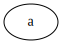

In [4]:
CausalOrder().prefix('a').view()

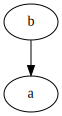

In [5]:
CausalOrder().prefix('a').prefix('b').view()

The **union** of two causal order is denoted as usual by $\Gamma \cup \Delta$ with the expected semantics.

In [6]:
def _causal_order_extend(self, other):
    assert isinstance(other, CausalOrder)
    for nvertex in other.vertices:
        #assert nvertex not in self.vertices
        if nvertex not in self.vertices:
            self.vertices.add(nvertex)
            self.out_edges[nvertex] = set()
            self.in_edges[nvertex] = set()
            
        self.out_edges[nvertex].update(copy.copy(other.out_edges[nvertex]))
        self.in_edges[nvertex].update(copy.copy(other.in_edges[nvertex]))

    return self

CausalOrder.extend = _causal_order_extend

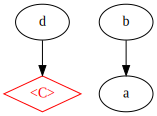

In [7]:
CausalOrder().prefix('a').prefix('b').extend(CausalOrder().prefix('syncC').prefix('d')).view()

The **join** of a label $B$ in a causal order $\Gamma$ is $\bigotimes_B \Gamma = \Gamma \setminus \{ \alpha \prec \beta \mid \alpha=B \lor \beta=B\} \cup \{ \gamma \prec \delta \mid \gamma \prec B \land B \prec \delta\}$

In [8]:
class CycleDetected(Exception):
    def __init__(self):
        super().__init__("Cycle detected in causal ordering")

def _causal_order_join(order, label):
    if label not in order.vertices:
        raise Exception('No such vertex: {}'.format(label))
    
    try:
        for out_vertex in order.in_edges[label]:
            for in_vertex in order.out_edges[label]:
                # add a direct edge
                order.out_edges[out_vertex].add(in_vertex)
                order.in_edges[in_vertex].add(out_vertex)
            
                # remove the label
                if label in order.out_edges[out_vertex]:
                    order.out_edges[out_vertex].remove(label)
                if label in order.in_edges[in_vertex]:
                    order.in_edges[in_vertex].remove(label)
    
    except RuntimeError:
        raise CycleDetected()
    
    del order.out_edges[label]
    del order.in_edges[label]
    order.vertices.remove(label)
        
    return order

CausalOrder.join = _causal_order_join

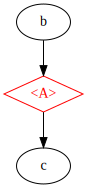

In [9]:
order = CausalOrder().prefix('syncA').prefix('b').extend(CausalOrder().prefix('c').prefix('syncA'))
order.view()

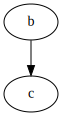

In [10]:
order.join('syncA').view()

### From processes to causal ordering

  - termination: $cov(0) = \emptyset$

In [11]:
def _term_causal_order(term):
    return CausalOrder()

Term.causal_order = _term_causal_order

In [12]:
Term().causal_order().view()

 - prefixing $cov(\alpha.P) = \alpha \prec cov(P)$

In [13]:
def _prefix_causal_order(prefix):
    cont_order = prefix.cont.causal_order()
    cont_order.prefix(prefix.act)
    return cont_order

Prefix.causal_order = _prefix_causal_order

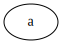

In [14]:
Prefix('a', Term()).causal_order().view()

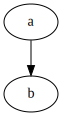

In [15]:
Prefix('a', Prefix('b', Term())).causal_order().view()

  - parallel : $cov(P\parallel Q) = cov(P) \cup cov(Q)$

In [16]:
def _parallel_causal_order(parallel):
    left_order = parallel.left.causal_order()
    right_order = parallel.right.causal_order()
    left_order.extend(right_order)
    return left_order

Parallel.causal_order = _parallel_causal_order

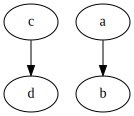

In [17]:
Parallel(Prefix('a', Prefix('b', Term())),
         Prefix('c', Prefix('d', Term()))).causal_order().view()

  - synchronization: $cov\left((\nu B)P\right) = \bigotimes_{\langle B \rangle} cov(P)$  

In [18]:
def _barrier_causal_order(bar_proc):
    order = bar_proc.proc.causal_order()

    # XXX : the join can be performed later on ...
    return order

Barrier.causal_order = _barrier_causal_order

  - barrier: $cov\left(\langle B \rangle P  \right)= \langle B \rangle \prec cov(P)$

In [19]:
def _synchro_causal_order(sync_proc):
    cont_order = sync_proc.proc.causal_order()
    cont_order.prefix('sync{}'.format(sync_proc.barrier))
    return cont_order

Synchro.causal_order = _synchro_causal_order

In [20]:
proc1 = Barrier('B', Prefix('fork', 
            par(Prefix('start1', Prefix('end1', Synchro('B', Term()))),
                Prefix('start2', Synchro('B', Prefix('end2', Term()))),
                Synchro('B', Prefix('start3', Prefix('end3', Term()))))))

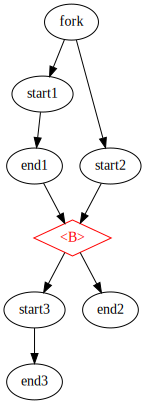

In [21]:
order = proc1.causal_order()
order.view()

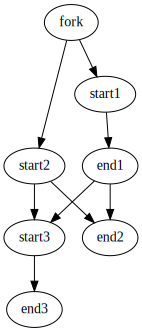

In [22]:
order.join('syncB').view()

In [23]:
proc2 = Barrier('A', Barrier('B'
        ,par(Prefix('a1', Synchro('A', Prefix('a2', Term())))
             ,Synchro('B', Prefix('b', Term()))
             ,Synchro('B', Synchro('A', Prefix('c', Term()))))))
print(proc2)

nu(A)[nu(B)[((a1.<A>a2.0 || <B>b.0) || <B><A>c.0)]]


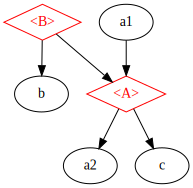

In [24]:
order = proc2.causal_order()
order.view()

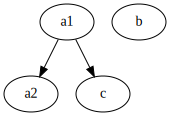

In [25]:
order.join('syncA').join('syncB').view()

A tree :

In [26]:
tree = Prefix('a', par(Prefix('b', Prefix('c', Term())),
                       Prefix('d', Parallel(Prefix('e', Term()),
                                            Prefix('f', Prefix('g', Term())))),
                       Prefix('h', Term())))

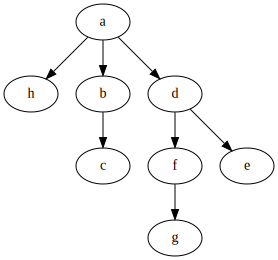

In [27]:
tree.causal_order().view()

A Join :

In [28]:
join_proc = Barrier('B', par(Prefix('a', Synchro('B', Term())),
                             Prefix('b', Synchro('B', Term())),
                             Prefix('c', Synchro('B', Prefix('j', Term())))))

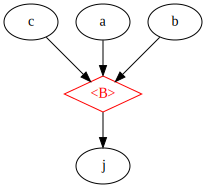

In [29]:
order = join_proc.causal_order()
order.view()

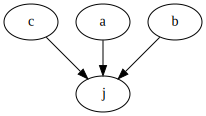

In [30]:
order.join('syncB').view()

The famous *N* :

In [31]:
n_proc = Barrier('B', Parallel(Prefix('a', Parallel(Synchro('B', Term()),
                                                    Prefix('b', Term()))),
                               Prefix('c', Synchro('B', Prefix('d', Term())))))

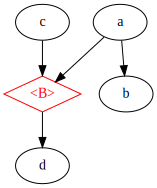

In [32]:
order  = n_proc.causal_order()
order.view()

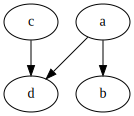

In [33]:
order.join('syncB').view()

A cyclic dependence

In [34]:
cycle = Barrier('B', Barrier('C', Parallel(Synchro('B', Synchro('C', Prefix('a', Term()))),
                                           Synchro('C', Synchro('B', Prefix('b', Term()))))))

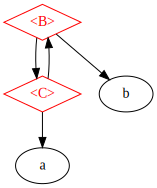

In [35]:
order = cycle.causal_order()
order.view()

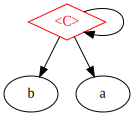

In [36]:
order.join('syncB').view()

In [37]:
try:
    order.join('syncC').view()
except Exception as e:
    print(e)

Cycle detected in causal ordering


In [38]:
f3j2 = Barrier('B', Barrier('C', Prefix('f',
                                par(Prefix('a', Synchro('B', Prefix('j1', Synchro('C', Term())))),
                                    Prefix('b', Synchro('B', Term())),
                                    Prefix('c', Synchro('C', Prefix('j2', Term())))))))
                                    

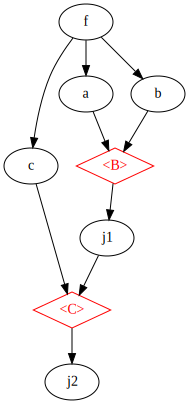

In [39]:
order = f3j2.causal_order()
order.view()

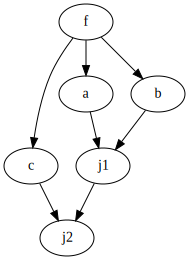

In [40]:
order.join('syncB').join('syncC').view()

In [41]:
example = Barrier('B', Barrier('C', Prefix('fork', 
            par(Prefix('start1', Synchro('B', Prefix('end1', Synchro('C', Term())))),
                Prefix('start2', Synchro('B', Prefix('end2', Term()))),
                Synchro('B', Prefix('start3', Synchro('C', Prefix('end3', Term()))))))))
print(example)

nu(B)[nu(C)[fork.((start1.<B>end1.<C>0 || start2.<B>end2.0) || <B>start3.<C>end3.0)]]


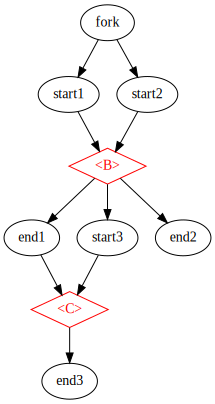

In [42]:
order = example.causal_order()
order.view()

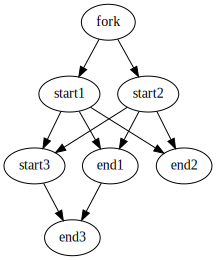

In [43]:
order.join('syncC').join('syncB').view()

In [44]:
deadlock = Barrier('B', Barrier('C', Prefix('fork', 
            par(Prefix('start1', Synchro('C', Prefix('end1', Synchro('B', Term())))),
                Prefix('start2', Synchro('B', Prefix('end2', Term()))),
                Synchro('B', Prefix('start3', Synchro('C', Prefix('end3', Term()))))))))
print(deadlock)

nu(B)[nu(C)[fork.((start1.<C>end1.<B>0 || start2.<B>end2.0) || <B>start3.<C>end3.0)]]


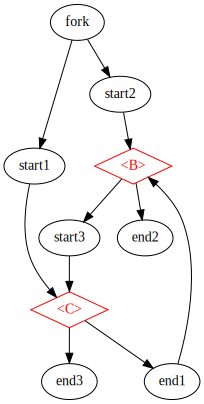

In [45]:
order = deadlock.causal_order()
order.view()

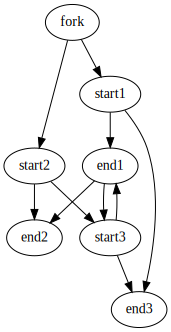

In [46]:
order.join('syncB').join('syncC').view()

In [47]:
minimal_dead = Barrier('B', Synchro('B', Prefix('a', Synchro('B', Term()))))
print(minimal_dead)

nu(B)[<B>a.<B>0]


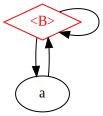

In [48]:
order = minimal_dead.causal_order()
order.view()

In [49]:
try:
    order.join('syncB')
except Exception as e:
    print(e)

Cycle detected in causal ordering


In [50]:
c2n_candidate1 = Barrier('B', Parallel(Prefix('act1', Synchro('B', Prefix('act2', Term()))),
                          Prefix('act3', Synchro('B', Prefix('act4', Term())))))
print(c2n_candidate1)

nu(B)[(act1.<B>act2.0 || act3.<B>act4.0)]


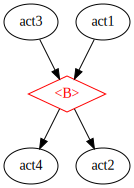

In [51]:
order = c2n_candidate1.causal_order()
order.view()

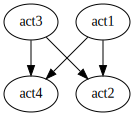

In [52]:
order.join('syncB')
order.view()

In [53]:
c2n_candidate2 = Barrier('B', par(Prefix('act1', Synchro('B', Term())),
                          Prefix('act2', Synchro('B', Term())),
                          Synchro('B', Prefix('tau', Parallel(Prefix('act3', Term()),
                                                               Prefix('act4', Term()))))))
print(c2n_candidate2)

nu(B)[((act1.<B>0 || act2.<B>0) || <B>tau.(act3.0 || act4.0))]


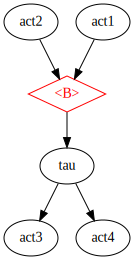

In [54]:
order = c2n_candidate2.causal_order()
order.view()

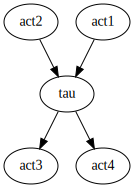

In [55]:
order.join('syncB')
order.view()

In [56]:
cycle_candidate3 = Barrier('B1', Barrier('B2', Barrier('B3', Barrier('B4',
                    par(Prefix('a1',Synchro('B1', Synchro('B2', Prefix('a2', Term())))),
                        Prefix('b1',Synchro('B1', Synchro('B4', Prefix('b2', Term())))),
                        Prefix('c1',Synchro('B3', Synchro('B2', Prefix('c2', Term())))),
                        Prefix('d1',Synchro('B3', Synchro('B4', Prefix('d2', Term())))))))))

In [57]:
print(cycle_candidate3)

nu(B1)[nu(B2)[nu(B3)[nu(B4)[(((a1.<B1><B2>a2.0 || b1.<B1><B4>b2.0) || c1.<B3><B2>c2.0) || d1.<B3><B4>d2.0)]]]]


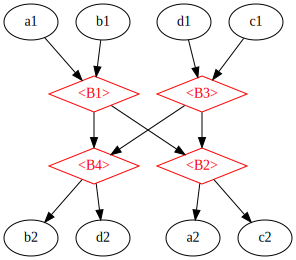

In [58]:
order = cycle_candidate3.causal_order()
order.view()

In [59]:
order.join('syncB1')
order.join('syncB2')
order.join('syncB3')
order.join('syncB4')

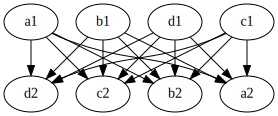

In [60]:
order.view()

In [61]:
cycle_candidate4 = Barrier('B',
                    par(Prefix('a1',Synchro('B', Prefix('a2', Term()))),
                        Prefix('b1',Synchro('B', Prefix('b2', Term()))),
                        Prefix('c1',Synchro('B', Prefix('c2', Term()))),
                        Prefix('d1',Synchro('B', Prefix('d2', Term())))))

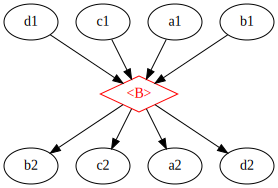

In [62]:
order = cycle_candidate4.causal_order()
order.view()

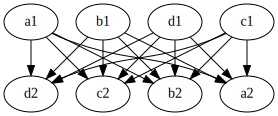

In [63]:
order.join('syncB')
order.view()

In [64]:
cycle_candidate5 = Barrier('A', Barrier('B', Barrier('C',
                     par(Prefix('a1', Synchro('A', Prefix('a2', Term()))),
                         Prefix('b1', par(Synchro('A', Synchro('B', Term())),
                                          Synchro('C', Synchro('B', Term())),
                                          Synchro('B', Prefix('b2', Term())))),                                               
                         Prefix('c1', Synchro('C', Prefix('c2', Term())))))))
print(cycle_candidate5)

nu(A)[nu(B)[nu(C)[((a1.<A>a2.0 || b1.((<A><B>0 || <C><B>0) || <B>b2.0)) || c1.<C>c2.0)]]]


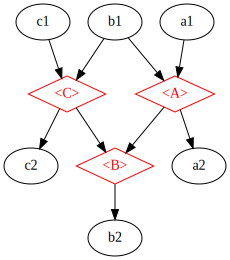

In [65]:
order = cycle_candidate5.causal_order()
order.view()

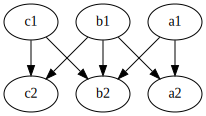

In [66]:
order.join('syncA')
order.join('syncB')
order.join('syncC')
order.view()

## Generalized join

In [67]:
def _join_all(order):
    for label in [lbl for lbl in order.vertices]:
        if label.startswith('sync'):
            order.join(label)
            
CausalOrder.join_all = _join_all

### Example

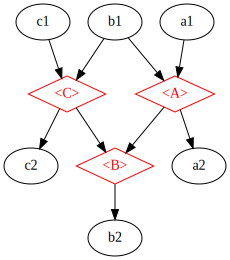

In [68]:
order = cycle_candidate5.causal_order()
order.view()

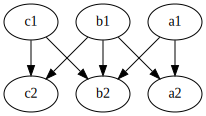

In [69]:
order.join_all()
order.view()

## From causal order to process

In [70]:
def _sync_all(order):
    nb_sync = 1
    joins = [join for join in order.joins]
    srcs = {join:[src for src in order.in_edges[join]] for join in joins}
    dests = {join:[dest for dest in order.out_edges[join]] for join in joins}
 
    for join in joins:
        #print("Join = {}".format(join))
        sync = 'sync{}'.format(nb_sync)
        order.vertices.add(sync)
        order.in_edges[sync] = set()
        order.out_edges[sync] = set()
        nb_sync += 1
        for src in srcs[join]:
            #print("src = {}".format(src))
            if src in order.out_edges:
                order.out_edges[src].remove(join)
            order.out_edges[src].add(sync)
            order.out_edges[sync].add(join)
        for dest in dests[join]:
            order.in_edges[dest].remove(join)
            order.in_edges[dest].add(sync)
            
CausalOrder.sync_all = _sync_all

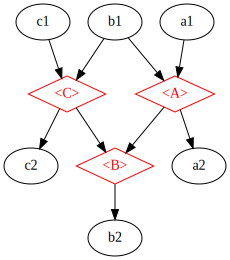

In [71]:
order = cycle_candidate5.causal_order()
order.view()

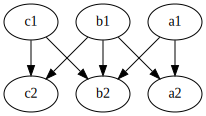

In [72]:
order.join_all()
order.view()

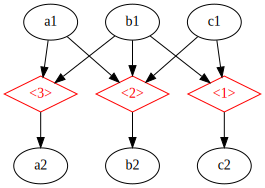

In [73]:
order.sync_all()
order.view()

## Some "real" examples

In [74]:
mips_order = mips_example.causal_order()

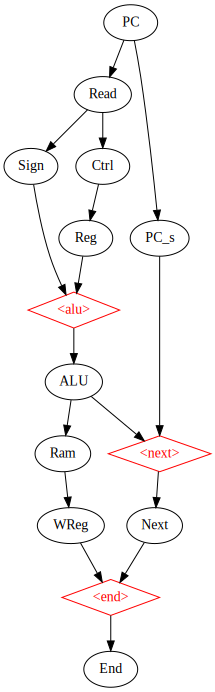

In [75]:
mips_order.view()

In [76]:
mips_order.join_all()

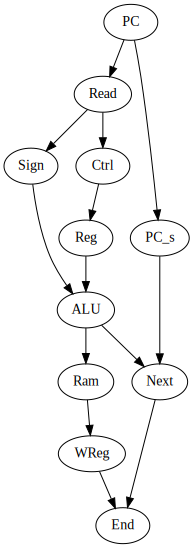

In [77]:
mips_order.view()

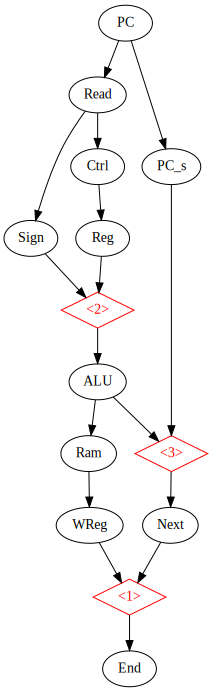

In [78]:
mips_order.sync_all()
mips_order.view()

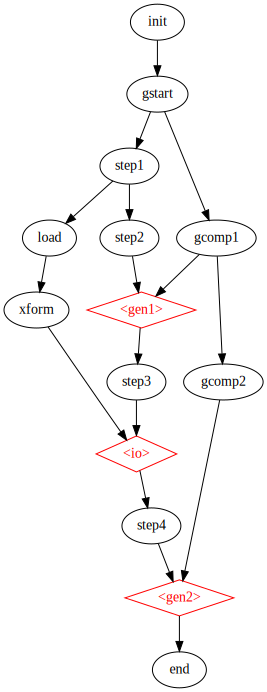

In [79]:
pargen_order = pargen_example.causal_order()
pargen_order.view()

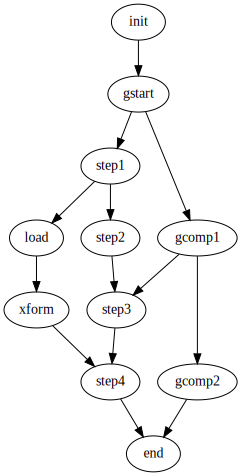

In [80]:
pargen_order.join_all()
pargen_order.view()

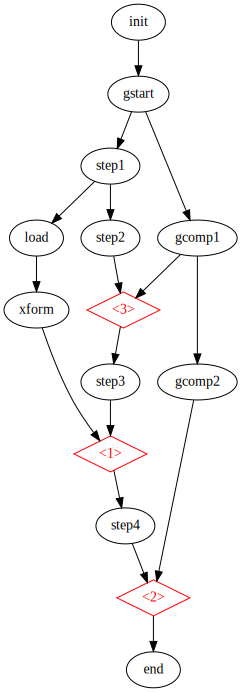

In [81]:
pargen_order.sync_all()
pargen_order.view()